In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class RoofDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
        #self.imgs = list(sorted(os.listdir("~/Desktop/Cranfield/GDP/python/roof_detection/Datasets/dataset1_new/images")))
        #self.masks = list(sorted(os.listdir("~/Desktop/Cranfield/GDP/python/roof_detection/Datasets/dataset1_new/masks")))
                          
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        #img_path = os.path.join("~/Desktop/Cranfield/GDP/python/roof_detection/Datasets/dataset1_new/images", self.imgs[idx])
        #mask_path = os.path.join("~/Desktop/Cranfield/GDP/python/roof_detection/Datasets/dataset1_new/masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not aerial images
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
%cd ~/Desktop/Cranfield/GDP/python/roof_detection

/Users/maximecollignon/Desktop/Cranfield/GDP/python/roof_detection


In [2]:
# Image redimensioning

if not os.path.exists('Datasets/dataset1_new'):
    os.makedirs('Datasets/dataset1_new')
    os.makedirs('Datasets/dataset1_new/images')
    os.makedirs('Datasets/dataset1_new/masks')

    for image in os.listdir('Datasets/dataset1/images'):
        image_path = os.path.join('Datasets/dataset1/images', image)
        #print(image)

        with Image.open(image_path) as img:

            label = image[:-4] + '_vis.tif'
            path_label = os.path.join('Datasets/dataset1','masks', label)

            label_image = Image.open(path_label)
            label_resized = label_image.resize((1000, 1000))
            label_pixels = label_resized.load()

            if np.any(np.array(label_resized) == 255):
                img_resized = img.resize((1000, 1000))
                label_resized = label_resized.convert('1')
                path_newimage = os.path.join('Datasets/dataset1_new/images', image)
                path_newlabel = os.path.join('Datasets/dataset1_new/masks', label[:-8]+'.tif')
                img_resized.save(path_newimage)
                label_resized.save(path_newlabel)




In [75]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 4096
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [76]:
#!git clone https://github.com/pytorch/vision.git
%cd vision
#!git checkout v0.3.0

#!cp references/detection/utils.py ../
#!cp references/detection/transforms.py ../
#!cp references/detection/coco_eval.py ../
#!cp references/detection/engine.py ../
#!cp references/detection/coco_utils.py ../

/Users/maximecollignon/Desktop/Cranfield/GDP/python/roof_detection/vision


In [77]:
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        #transforms.append(torchvision.transforms.RandomRotation(180))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = RoofDataset('../Datasets/dataset1_new', get_transform(train=True))
dataset_test = RoofDataset('../Datasets/dataset1_new', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-100])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [78]:
device = torch.device('cpu')# if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and roof
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [79]:
from engine import train_one_epoch, evaluate

# number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/390]  eta: 0:34:50  lr: 0.000036  loss: 11.4925 (11.4925)  loss_classifier: 0.8100 (0.8100)  loss_box_reg: 0.0556 (0.0556)  loss_mask: 10.5385 (10.5385)  loss_objectness: 0.0790 (0.0790)  loss_rpn_box_reg: 0.0093 (0.0093)  time: 5.3612  data: 0.0927  max mem: 0
Epoch: [0]  [ 10/390]  eta: 0:32:56  lr: 0.000292  loss: 4.8484 (6.4494)  loss_classifier: 0.6016 (0.5746)  loss_box_reg: 0.0779 (0.0793)  loss_mask: 3.8682 (5.5353)  loss_objectness: 0.1255 (0.2168)  loss_rpn_box_reg: 0.0128 (0.0433)  time: 5.2013  data: 0.0607  max mem: 0
Epoch: [0]  [ 20/390]  eta: 0:31:20  lr: 0.000549  loss: 2.4165 (4.3198)  loss_classifier: 0.2054 (0.3447)  loss_box_reg: 0.0803 (0.0736)  loss_mask: 1.9716 (3.7042)  loss_objectness: 0.1141 (0.1534)  loss_rpn_box_reg: 0.0252 (0.0439)  time: 5.0695  data: 0.0589  max mem: 0
Epoch: [0]  [ 30/390]  eta: 0:30:39  lr: 0.000806  loss: 0.7137 (3.1135)  loss_classifier: 0.0554 (0.2497)  loss_box_reg: 0.0812 (0.0764)  loss_mask: 0.4691 (2.6387)  loss

In [80]:
torch.save(model, '../../models/roof_detector-3.pt')

## Inference

In [81]:
# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'roof']
device = torch.device('cpu') #if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [84]:
%cd ~/Desktop/Cranfield/GDP/python/roof_detection

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    img = img.convert('RGB')
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    img = img.to(device)
    model = torch.load('../models/roof_detector-3.pt')
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path,
                     confidence=0.5, 
                     masks=None, boxes=None, pred_cls=None, classes=None,
                     rect_th=2, 
                     text_size=2, 
                     text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    if masks == None:
      masks, boxes, pred_cls = get_prediction(img_path, confidence)
    print(boxes)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
      #cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th)
      (x1,y1) = boxes[i][0]
      (x2,y2) = boxes[i][0]
      if classes != None:
        if pred_cls < 0.5: 
          cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color='r', thickness=rect_th)
          cv2.putText(img, 'Flat', (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
        else:
          cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color='b', thickness=rect_th)
          cv2.putText(img, 'Other', (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
      else:
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color=(0,255,0), thickness=rect_th)
      #cv2.putText(img,pred_cls[i], (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, text_size/10, (0,255,0),thickness=10)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

/Users/maximecollignon/Desktop/Cranfield/GDP/python/roof_detection


[[(11.192055, 0.0), (1000.0, 999.89075)]]


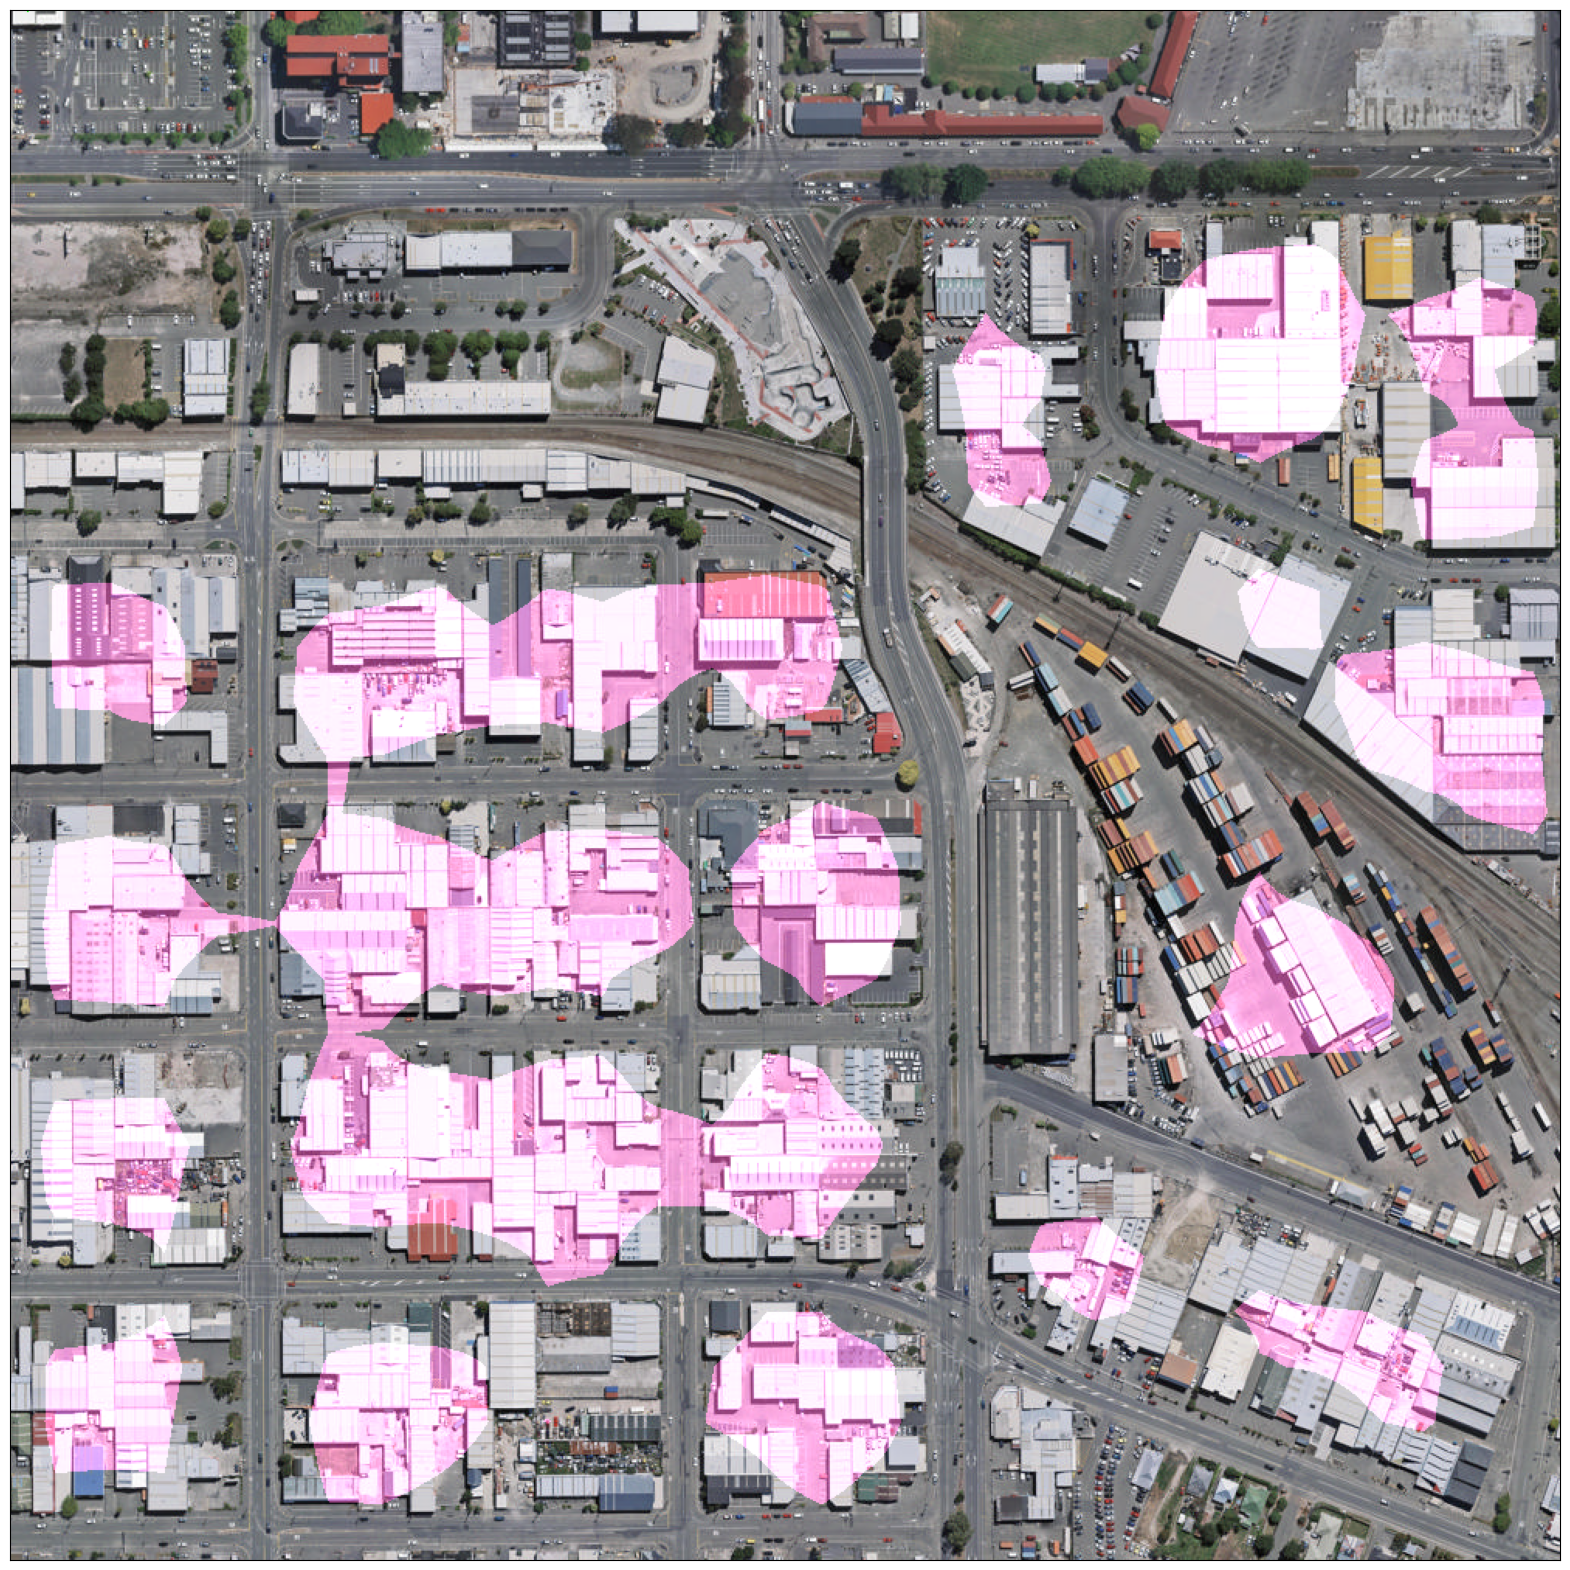

In [86]:
segment_instance('Datasets/dataset1_new/images/christchurch_650.tif', confidence=0.5)
#650